In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# فصل ۲ — مبانی داده و پیش‌پردازش
## درس ۳: تبدیل داده و کُدگذاری (Encoding)



### مرور کلی

در یادگیری ماشین کلاسیک، «مدل بهتر» اغلب یعنی **نمایش بهتر داده**. دو پایپ‌لاین با مدل یکسان می‌توانند
به دلیل تفاوت در پیش‌پردازش رفتار کاملاً متفاوتی داشته باشند.

این درس روی دو عمل اصلی تمرکز دارد:

- **تبدیل‌های عددی**: تغییر مقیاس، شکل توزیع و حساسیت به برون‌زدگی‌ها.
- **کُدگذاری‌های دسته‌ای**: تعریف اینکه دسته‌ها چگونه به هندسه در فضای ویژگی تبدیل شوند.

مهارتی که شما را از سطح متوسط به سطح پیشرفته می‌برد این است:
انتخاب تبدیل و کُدگذاری **بر اساس مکانیک مدل**، نه از روی عادت.

پس از این درس باید بتوانید به این پرسش‌ها پاسخ دهید:

1. چه زمانی مقیاس‌دهی فقط سرعت آموزش را تغییر نمی‌دهد، بلکه تعمیم را هم عوض می‌کند؟
2. چه زمانی تبدیل‌های یکنواخت (لگ/توانی/کوانتایل) یادگیری را بهتر می‌کنند؟
3. چه زمانی یک‌-هات کمک می‌کند و چه زمانی آسیب می‌زند (واریانس، بعد، اسپارس بودن)؟
4. چرا Target Encoding به‌راحتی دچار نشت می‌شود و چگونه جلوی آن را می‌گیریم؟
5. چگونه یک آرتیفکت واحد می‌سازیم تا پیش‌پردازش و مدل در زمان استنتاج سازگار بمانند؟

برای اینکه انتقال مهارت را ببینید (و محدودیت‌ها را هم بشناسید)، از چند دیتاست استفاده می‌کنیم.


In [2]:
import os
import tempfile
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder,
    StandardScaler, RobustScaler,
    PowerTransformer, QuantileTransformer,
    KBinsDiscretizer, PolynomialFeatures
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import f1_score
from sklearn.feature_extraction import FeatureHasher
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
import joblib

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

SAMPLES = {'diabetes': 'Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification\n6,148,72,35,0,33.6,0.627,50,Diabetic\n1,85,66,29,0,26.6,0.351,31,Non-Diabetic\n8,183,64,0,0,23.3,0.672,32,Diabetic\n1,89,66,23,94,28.1,0.167,21,Non-Diabetic\n0,137,40,35,168,43.1,2.288,33,Diabetic\n', 'drug200': 'Age,Sex,BP,Cholesterol,Na_to_K,Drug\n23,F,HIGH,HIGH,25.355,DrugY\n47,M,LOW,HIGH,13.093,drugC\n47,M,LOW,HIGH,10.114,drugC\n28,F,NORMAL,HIGH,7.798,drugX\n61,F,LOW,HIGH,18.043,DrugY\n22,F,NORMAL,HIGH,8.607,drugX\n', 'wine': 'fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality\n7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6\n6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6\n8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6\n7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6\n7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6\n8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6\n', 'house_prices': 'Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood\n1,114300,1790,2,2,2,No,East\n2,114200,2030,4,2,3,No,East\n3,114800,1740,3,2,1,No,East\n4,94700,1980,3,2,3,No,East\n5,119800,2130,3,3,3,No,East\n', 'listings': 'id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license\n13913,Holiday London DB Room Let-on going,54730,Alina,,Islington,51.56861,-0.1127,Private room,57,1,51,2025-02-09,0.29,3,344,10,\n15400,Bright Chelsea  Apartment. Chelsea!,60302,Philippa,,Kensington and Chelsea,51.4878,-0.16813,Entire home/apt,,4,96,2024-04-28,0.52,1,11,2,\n17402,Very Central Modern 3-Bed/2 Bath By Oxford St W1,67564,Liz,,Westminster,51.52195,-0.14094,Entire home/apt,510,3,56,2024-02-19,0.33,5,293,0,\n24328,Battersea live/work artist house,41759,Joe,,Wandsworth,51.47072,-0.16266,Entire home/apt,213,90,94,2022-07-19,0.54,1,194,0,\n31036,Bright  compact 1 Bedroom Apartment Brick Lane,133271,Hendryks,,Tower Hamlets,51.52425,-0.06997,Entire home/apt,100,2,126,2025-02-20,0.70,8,353,3,\n'}


In [3]:
def load_csv_or_sample(path: str, sample_key: str) -> pd.DataFrame:
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(StringIO(SAMPLES[sample_key]))

def augment_by_bootstrap(df: pd.DataFrame, n_rows: int = 600, noise_scale: float = 0.03) -> pd.DataFrame:
    out = df.sample(n=n_rows, replace=True, random_state=RANDOM_SEED).reset_index(drop=True)
    num_cols = out.select_dtypes(include=[np.number]).columns.tolist()
    if num_cols:
        for c in num_cols:
            col = out[c].astype(float)
            s = np.nanstd(col.values)
            if np.isfinite(s) and s > 0:
                out[c] = col + rng.normal(0, noise_scale * s, size=len(out))
    return out

def make_ohe(handle_unknown="ignore"):
    try:
        return OneHotEncoder(handle_unknown=handle_unknown, sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown=handle_unknown, sparse=False)



## ۱) تبدیل‌های عددی: مقیاس، شکل و هندسه

یک تبدیل عددی تابعی $t(\cdot)$ است که روی یک ویژگی اعمال می‌شود:

$$x \mapsto t(x)$$

در عمل سه اثر مهم داریم:

1. **اثر مقیاس**: فاصله‌ها و منظم‌سازی به اندازه ویژگی‌ها وابسته‌اند.
2. **اثر شکل**: چولگی/برون‌زدگی رفتار گرادیان و برآورد مقاوم را تغییر می‌دهد.
3. **اثر هندسه**: بازه‌بندی/کوانتایل‌ها تعریف «نزدیکی» را در فضای نمایش عوض می‌کنند.

در ادامه مقیاس‌دهی، تبدیل توانی، تبدیل کوانتایل و گسسته‌سازی را بررسی می‌کنیم.


In [4]:
wine_path = "../../../Datasets/Classification/Wine_Quality.csv"
wine = load_csv_or_sample(wine_path, "wine")
wine.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
wine.describe().T


,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000



### ۱.۱ StandardScaler در برابر RobustScaler

- StandardScaler از میانگین و انحراف معیار استفاده می‌کند:
  $$z=\frac{x-\mu}{\sigma}$$
- RobustScaler از میانه و IQR استفاده می‌کند (کم‌حساس‌تر به برون‌زدگی).

این تبدیل‌ها درون هر ویژگی خطی‌اند و ترتیب مقادیر را تغییر نمی‌دهند.


In [6]:
num_cols = wine.select_dtypes(include=[np.number]).columns.tolist()
X_num = wine[num_cols].copy()

std = StandardScaler().fit_transform(X_num)
rob = RobustScaler().fit_transform(X_num)

pd.concat([
    X_num.head(3),
    pd.DataFrame(std, columns=[f"{c}__std" for c in num_cols]).head(3),
    pd.DataFrame(rob, columns=[f"{c}__rob" for c in num_cols]).head(3),
], axis=1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,citric acid__rob,residual sugar__rob,chlorides__rob,free sulfur dioxide__rob,total sulfur dioxide__rob,density__rob,pH__rob,sulphates__rob,alcohol__rob,quality__rob
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,...,0.333333,1.890244,0.142857,0.478261,0.610169,1.658481,-0.947368,-0.142857,-0.842105,0.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,...,0.166667,-0.439024,0.428571,-0.869565,-0.033898,0.059395,0.631579,0.142857,-0.473684,0.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,...,0.666667,0.207317,0.500000,-0.173913,-0.627119,0.310680,0.421053,-0.214286,-0.157895,0.0



### ۱.۲ تبدیل توانی (Yeo–Johnson)

تبدیل‌های توانی می‌توانند چولگی را کاهش دهند و واریانس را پایدارتر کنند. Yeo–Johnson راحت است چون صفر/منفی را هم پشتیبانی می‌کند.

چولگی را مقایسه می‌کنیم و توزیع یک ویژگی را رسم می‌کنیم.


In [7]:
feature = "residual sugar" if "residual sugar" in wine.columns else num_cols[0]
x = wine[[feature]].astype(float).copy()

pt = PowerTransformer(method="yeo-johnson", standardize=False)
x_yj = pt.fit_transform(x)

pd.Series(x[feature]).skew(), pd.Series(x_yj[:, 0]).skew()


(np.float64(1.0770937564240868), np.float64(0.0013974458218011967))

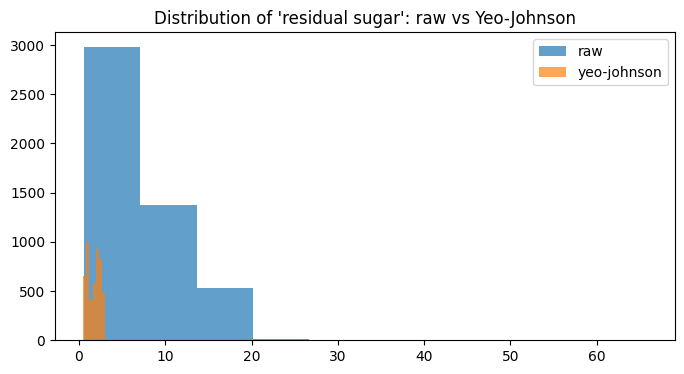

In [8]:
plt.figure(figsize=(8,4))
plt.hist(x[feature].dropna(), bins=10, alpha=0.7, label="raw")
plt.hist(pd.Series(x_yj[:,0]).dropna(), bins=10, alpha=0.7, label="yeo-johnson")
plt.title(f"Distribution of '{feature}': raw vs Yeo-Johnson")
plt.legend()
plt.show()



### ۱.۳ تبدیل کوانتایل (مبتنی بر رتبه)

تبدیل کوانتایل داده را بر اساس رتبه تجربی نگاشت می‌کند و اثر برون‌زدگی را کم می‌کند.

یک انتخاب رایج `output_distribution="normal"` است تا حاشیه‌ها تقریباً گاوسی شوند.


In [9]:
qt = QuantileTransformer(output_distribution="normal", random_state=RANDOM_SEED)
x_qt = qt.fit_transform(x)

pd.DataFrame({"raw": x[feature].astype(float).values, "qt_normal": x_qt[:,0]}).head()


,raw,qt_normal
0,20.7,2.851242
1,1.6,-0.774833
2,6.9,0.232930
3,8.5,0.512061
4,8.5,0.512061



### ۱.۴ گسسته‌سازی (بازه‌بندی)

بازه‌بندی یک متغیر پیوسته را به سطوح گسسته تبدیل می‌کند. گاهی برای تفسیرپذیری یا برای مدل‌هایی که ساختار آستانه‌ای را بهتر می‌گیرند مفید است.

از باین‌های کوانتایلی استفاده می‌کنیم تا هر بازه فراوانی مشابه داشته باشد.


In [10]:
kbd = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")
x_bins = kbd.fit_transform(x)

pd.DataFrame({"raw": x[feature].astype(float).values, "bin": x_bins[:,0].astype(int)}).head(12)


,raw,bin
0,20.70,3
1,1.60,0
2,6.90,2
3,8.50,2
4,8.50,2
5,6.90,2
6,7.00,2
7,20.70,3
8,1.60,0
9,1.50,0



### ۱.۵ مقیاس‌دهی و منظم‌سازی: ضرایب Ridge

تابع هدف Ridge:

$$\min_w \sum_i (y_i - w^\top x_i)^2 + \lambda \|w\|_2^2$$

مقیاس‌دهی معنی $\|w\|_2^2$ را بین ویژگی‌ها تغییر می‌دهد. ضرایب با و بدون مقیاس‌دهی را مقایسه می‌کنیم.


In [11]:
wine2 = augment_by_bootstrap(wine, n_rows=700)
Xw = wine2.drop(columns=["quality"])
yw = wine2["quality"].astype(float)

ridge_raw = Ridge(alpha=5.0, random_state=RANDOM_SEED).fit(Xw, yw)
coef_raw = pd.Series(ridge_raw.coef_, index=Xw.columns).sort_values(key=np.abs, ascending=False)

ridge_scaled = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=5.0, random_state=RANDOM_SEED))
]).fit(Xw, yw)
coef_scaled = pd.Series(ridge_scaled.named_steps["ridge"].coef_, index=Xw.columns).sort_values(key=np.abs, ascending=False)

pd.DataFrame({"coef_raw": coef_raw, "coef_scaled": coef_scaled}).head(10)


,coef_raw,coef_scaled
alcohol,0.328354,0.266171
chlorides,-0.046602,0.014912
citric acid,-0.217980,-0.057447
density,-0.005102,-0.321740
fixed acidity,0.019564,0.092345
free sulfur dioxide,0.004152,0.040403
pH,0.167128,0.071140
residual sugar,0.021966,0.323804
sulphates,0.538895,0.106577
total sulfur dioxide,-0.001251,-0.004372



### ۱.۶ مثال kNN: مقیاس‌دهی فاصله‌ها و امتیاز را تغییر می‌دهد

kNN به فاصله‌ها وابسته است. بدون مقیاس‌دهی، یک ویژگی با دامنه بزرگ می‌تواند معیار فاصله را غالب کند.

kNN را روی دیتاست دیابت با و بدون مقیاس‌دهی و با اعتبارسنجی سبک ارزیابی می‌کنیم.


In [12]:
diab_path = "../../../Datasets/Classification/diabetes.csv"
diab = load_csv_or_sample(diab_path, "diabetes")
diab2 = augment_by_bootstrap(diab, n_rows=650)

X_d = diab2.drop(columns=["classification"])
y_d = (diab2["classification"].astype(str).str.contains("Diabetic", case=False)).astype(int)

knn_raw = Pipeline([("knn", KNeighborsClassifier(n_neighbors=7))])
knn_scaled = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=7))])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
f1_raw = cross_val_score(knn_raw, X_d, y_d, cv=cv, scoring="f1").mean()
f1_scaled = cross_val_score(knn_scaled, X_d, y_d, cv=cv, scoring="f1").mean()
f1_raw, f1_scaled


(np.float64(1.0), np.float64(1.0))


## ۲) کُدگذاری ویژگی‌های دسته‌ای

کُدگذاری تعیین می‌کند دسته‌ها چگونه به عدد تبدیل شوند. نمایشی که انتخاب می‌کنید روی موارد زیر اثر می‌گذارد:

- بعد فضا (تعداد ویژگی‌های تولیدشده)،
- اسپارس بودن،
- اینکه مدل بتواند اثرهای غیر یکنواخت دسته‌ها را نشان دهد یا نه،
- مقاومت نسبت به دسته‌های جدید.

از دیتاست drug استفاده می‌کنیم، یک‌-هات و ترتیبی را نشان می‌دهیم و macro-F1 را مقایسه می‌کنیم.


In [13]:
drug_path = "../../../Datasets/Classification/drug200.csv"
drug = load_csv_or_sample(drug_path, "drug200")
drug.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY



### ۲.۱ یک‌-هات و دسته‌های جدید

`handle_unknown="ignore"` از شکست در زمان استنتاج جلوگیری می‌کند اگر دسته جدید ظاهر شود.


In [14]:
ohe = make_ohe(handle_unknown="ignore")
ohe.fit(drug[["Sex","BP","Cholesterol"]])
ohe.get_feature_names_out()


array(['Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW', 'BP_NORMAL',
       'Cholesterol_HIGH', 'Cholesterol_NORMAL'], dtype=object)

In [15]:
X_new = pd.DataFrame({"Sex":["F"], "BP":["VERY_HIGH"], "Cholesterol":["HIGH"]})
pd.DataFrame(ohe.transform(X_new), columns=ohe.get_feature_names_out())


,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0



### ۲.۲ کُدگذاری ترتیبی

کُدگذاری ترتیبی فقط وقتی معنی دارد که ترتیب واقعی باشد. اینجا یک ترتیب معقول برای BP و Cholesterol استفاده می‌کنیم.


In [16]:
sex_cats = ["F","M"]
bp_cats = ["LOW","NORMAL","HIGH"]
chol_cats = ["LOW","NORMAL","HIGH"]

# Normalize category strings to avoid case/whitespace mismatches
drug_norm = drug.copy()
for _c in ["Sex","BP","Cholesterol"]:
    drug_norm[_c] = drug_norm[_c].astype(str).str.strip().str.upper()

try:
    ord_enc = OrdinalEncoder(
        categories=[sex_cats, bp_cats, chol_cats],
        handle_unknown="use_encoded_value",
        unknown_value=-1,
    )
except TypeError:
    # Fallback for older scikit-learn versions
    ord_enc = OrdinalEncoder(categories=[sex_cats, bp_cats, chol_cats])
ord_enc.fit(drug_norm[["Sex","BP","Cholesterol"]])
ord_enc.transform(drug_norm[["Sex","BP","Cholesterol"]]).astype(int)[:5]


array([[0, 2, 2],
       [1, 0, 2],
       [1, 0, 2],
       [0, 1, 2],
       [0, 0, 2]])


### ۲.۳ اثر قابل اندازه‌گیری: مقایسه macro-F1

دو پایپ‌لاین می‌سازیم:

- یک‌-هات برای دسته‌ای + مقیاس‌دهی عددی + رگرسیون لجستیک
- ترتیبی برای دسته‌ای + مقیاس‌دهی عددی + رگرسیون لجستیک

macro-F1 را با اعتبارسنجی ۳ فولد محاسبه می‌کنیم تا هم سریع باشد و هم آموزنده.


In [17]:
drug2 = augment_by_bootstrap(drug, n_rows=900)

# Normalize categories for consistent encoding
drug2_norm = drug2.copy()
for _c in ["Sex","BP","Cholesterol"]:
    drug2_norm[_c] = drug2_norm[_c].astype(str).str.strip().str.upper()
X = drug2_norm.drop(columns=["Drug"])
y = drug2["Drug"].astype(str)

cat_cols = ["Sex","BP","Cholesterol"]
num_cols = ["Age","Na_to_K"]

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

pre_ohe = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", make_ohe("ignore"))]), cat_cols),
])

pre_ord = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ord", ord_enc)]), cat_cols),
])

clf_ohe = Pipeline([("pre", pre_ohe), ("lr", LogisticRegression(max_iter=2000))])
clf_ord = Pipeline([("pre", pre_ord), ("lr", LogisticRegression(max_iter=2000))])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
f1_ohe = cross_val_score(clf_ohe, X, y, cv=cv, scoring="f1_macro").mean()
f1_ord = cross_val_score(clf_ord, X, y, cv=cv, scoring="f1_macro").mean()
f1_ohe, f1_ord


(np.float64(0.9811563679464151), np.float64(0.9573152430009807))


### ۲.۴ کاردینالیتی بالا: هش و کُدگذاری فراوانی

برای دسته‌های با کاردینالیتی بسیار بالا، یک‌-هات ممکن است بیش از حد بزرگ شود.

- هش: نمایش با بعد ثابت، امکان برخورد.
- کُدگذاری فراوانی: فشرده‌سازی به یک ویژگی عددی؛ احتمال مخلوط‌شدن محبوبیت با معنا.

هر دو را روی برچسب‌های مصنوعی شهر نشان می‌دهیم.


In [18]:
cities = [f"city_{i}" for i in range(50)]
df_hash = pd.DataFrame({"city": rng.choice(cities, size=60, replace=True)})

hasher = FeatureHasher(n_features=8, input_type="string")
X_h = hasher.transform(df_hash["city"].astype(str).apply(lambda x: [x]))
X_h.toarray()[:5]


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [19]:
freq = df_hash["city"].value_counts(normalize=True)
df_hash["city_freq"] = df_hash["city"].map(freq)
df_hash.head()


,city,city_freq
0,city_30,0.016667
1,city_10,0.033333
2,city_8,0.016667
3,city_24,0.050000
4,city_35,0.066667



## ۳) مقادیر گمشده درون پایپ‌لاین

مدیریت گمشده‌ها بخشی از طراحی تبدیل است. یک پایپ‌لاین مقاوم معمولاً:

- نوع داده را امن تبدیل می‌کند (مثلاً رشته‌های عددی به float)،
- ایمپیوت عددی و دسته‌ای را جدا انجام می‌دهد،
- در صورت نیاز Missing Indicator اضافه می‌کند.

یک پایپ‌لاین طبقه‌بندی سبک روی listings می‌سازیم و با/بدون Missing Indicator عددی مقایسه می‌کنیم.


In [20]:
listings_path = "../../../Datasets/Regression/listings.csv"
listings = load_csv_or_sample(listings_path, "listings")

df_l = listings[["neighbourhood","room_type","price","minimum_nights","number_of_reviews"]].copy()
df_l["price"] = pd.to_numeric(df_l["price"], errors="coerce")

df_l2 = augment_by_bootstrap(df_l, n_rows=700)
median_price = df_l2["price"].median()
y = (df_l2["price"] >= median_price).astype(int)

# Inject extra missingness
m1 = rng.random(len(df_l2)) < 0.10
df_l2.loc[m1, "room_type"] = np.nan
m2 = rng.random(len(df_l2)) < 0.10
df_l2.loc[m2, "minimum_nights"] = np.nan

X = df_l2.copy()

cat_features = ["neighbourhood","room_type"]
num_features = ["price","minimum_nights","number_of_reviews"]


In [21]:
numeric_with_ind = Pipeline([
    ("imp", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", RobustScaler()),
])

numeric_no_ind = Pipeline([
    ("imp", SimpleImputer(strategy="median", add_indicator=False)),
    ("scaler", RobustScaler()),
])

categorical_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe("ignore")),
])

pre_with = ColumnTransformer([
    ("num", numeric_with_ind, num_features),
    ("cat", categorical_pipe, cat_features),
])

pre_no = ColumnTransformer([
    ("num", numeric_no_ind, num_features),
    ("cat", categorical_pipe, cat_features),
])

clf_with = Pipeline([("pre", pre_with), ("lr", LogisticRegression(max_iter=2000))])
clf_no = Pipeline([("pre", pre_no), ("lr", LogisticRegression(max_iter=2000))])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
f1_with = cross_val_score(clf_with, X, y, cv=cv, scoring="f1").mean()
f1_no = cross_val_score(clf_no, X, y, cv=cv, scoring="f1").mean()
f1_with, f1_no


(np.float64(0.9673824080867367), np.float64(0.926851611788091))


## ۴) Target Encoding: جلوگیری از نشت

Target encoding دسته‌ها را با آمار هدف جایگزین می‌کند:

$$\text{TE}(c) = \mathbb{E}[y \mid x=c]$$

اگر TE روی کل داده محاسبه شود، اطلاعات برچسب به ویژگی‌ها نشت می‌کند.

یک‌-هات را با انکودر نشتی مقایسه می‌کنیم، سپس TE به‌صورت out-of-fold را محاسبه کرده و امتیاز می‌گیریم.


In [22]:
df_te = pd.DataFrame({
    "city": rng.choice([f"city_{i}" for i in range(60)], size=900, replace=True),
    "x": rng.normal(size=900),
})
city_effect_map = pd.Series(rng.normal(0, 0.8, size=60), index=[f"city_{i}" for i in range(60)])
logit = 0.6 * df_te["x"] + df_te["city"].map(city_effect_map).values
p = 1 / (1 + np.exp(-logit))
df_te["y"] = (rng.random(900) < p).astype(int)
df_te.head()


,city,x,y
0,city_10,0.934926,0
1,city_40,-0.395509,0
2,city_27,-0.963819,0
3,city_26,1.543649,1
4,city_45,0.872912,1


In [23]:
class LeakyTargetMeanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col="city"):
        self.col = col

    def fit(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        self.global_mean_ = float(y.mean())
        self.means_ = y.groupby(X[self.col]).mean().to_dict()
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        enc = X[self.col].map(self.means_).fillna(self.global_mean_).astype(float)
        return enc.to_frame(name=f"{self.col}_te").values

class CVTargetMeanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col="city", n_splits=3, smoothing=20.0, random_state=42):
        self.col = col
        self.n_splits = n_splits
        self.smoothing = smoothing
        self.random_state = random_state

    def fit_transform_oof(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        oof = np.empty(len(X), dtype=float)

        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        for tr, va in skf.split(X, y):
            X_tr, y_tr = X.iloc[tr], y.iloc[tr]
            global_mean = float(y_tr.mean())

            stats = y_tr.groupby(X_tr[self.col]).agg(["mean","count"])
            smooth = (stats["count"] * stats["mean"] + self.smoothing * global_mean) / (stats["count"] + self.smoothing)
            means = smooth.to_dict()

            X_va = X.iloc[va]
            oof[va] = X_va[self.col].map(means).fillna(global_mean).astype(float).values

        return oof.reshape(-1, 1)


In [24]:
X = df_te[["city","x"]].copy()
y = df_te["y"].astype(int)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

baseline = Pipeline([
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), ["x"]),
        ("cat", make_ohe("ignore"), ["city"]),
    ])),
    ("lr", LogisticRegression(max_iter=2000)),
])

leaky = Pipeline([
    ("pre", ColumnTransformer([
        ("x", StandardScaler(), ["x"]),
        ("te", LeakyTargetMeanEncoder("city"), ["city"]),
    ])),
    ("lr", LogisticRegression(max_iter=2000)),
])

baseline_f1 = cross_val_score(baseline, X, y, cv=cv, scoring="f1").mean()
leaky_f1 = cross_val_score(leaky, X, y, cv=cv, scoring="f1").mean()
baseline_f1, leaky_f1


(np.float64(0.6234416657279112), np.float64(0.6222079466616802))

In [25]:
enc = CVTargetMeanEncoder(col="city", n_splits=3, smoothing=20.0, random_state=RANDOM_SEED)
city_te_oof = enc.fit_transform_oof(X[["city"]], y)

X_oof = np.column_stack([StandardScaler().fit_transform(X[["x"]]), city_te_oof])

f1s = []
for tr, va in cv.split(X_oof, y):
    lr = LogisticRegression(max_iter=2000)
    lr.fit(X_oof[tr], y.iloc[tr])
    pred = lr.predict(X_oof[va])
    f1s.append(f1_score(y.iloc[va], pred))
float(np.mean(f1s)), float(np.std(f1s))


(0.6011980246637522, 0.016690419450675384)


## ۵) پیش‌پردازش مختلط برای رگرسیون + ذخیره پایپ‌لاین

یک خط پایهٔ قوی برای رگرسیون جدولی:

- عددی: ایمپیوت + مقیاس‌دهی
- دسته‌ای: ایمپیوت + یک‌-هات
- مدل: Ridge Regression

MAE را ارزیابی می‌کنیم و سپس پایپ‌لاین آموزش‌دیده را به‌عنوان یک آرتیفکت واحد ذخیره می‌کنیم.


In [26]:
hp_path = "../../../Datasets/Regression/house-prices.csv"
hp = load_csv_or_sample(hp_path, "house_prices")
hp2 = augment_by_bootstrap(hp, n_rows=700)
hp2["Price"] = hp2["Price"].astype(float)

# Inject missingness
m1 = rng.random(len(hp2)) < 0.05
hp2.loc[m1, "Brick"] = np.nan

X = hp2.drop(columns=["Price"])
y = hp2["Price"].astype(float)

cat_cols = ["Brick","Neighborhood"]
num_cols = [c for c in X.columns if c not in cat_cols]

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median", add_indicator=True)), ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", make_ohe("ignore"))])

pre = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])

reg = Pipeline([("pre", pre), ("model", Ridge(alpha=3.0, random_state=RANDOM_SEED))])

cv_r = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
mae = -cross_val_score(reg, X, y, cv=cv_r, scoring="neg_mean_absolute_error").mean()
mae


np.float64(7869.77960783777)


### ۵.۱ ذخیره و بارگذاری

ذخیره کل پایپ‌لاین (نه فقط مدل) تضمین می‌کند در زمان استنتاج همان پیش‌پردازش اعمال می‌شود.


In [27]:
reg.fit(X, y)

tmp = tempfile.mkdtemp()
artifact_path = os.path.join(tmp, "house_price_ridge_pipeline.joblib")
joblib.dump(reg, artifact_path)

loaded = joblib.load(artifact_path)
loaded.predict(X.head(3))


array([130220.67981633, 100356.06301993, 146399.0365262 ])


## ۶) تمرین‌ها (پیشنهادی)

1. آزمایش مقیاس‌دهی kNN را برای چند مقدار `n_neighbors` تکرار کنید و واریانس امتیازها را مقایسه کنید.
2. برای دیابت، `RobustScaler` را با `StandardScaler` مقایسه کنید و توضیح دهید چه زمانی انتظار دارید هرکدام کمک کند.
3. برای یک ویژگی مصنوعی پرکاردینالیتی، یک‌-هات را با هش جایگزین کنید و اثر برخورد روی معیارها را بررسی کنید.
4. در بخش Target Encoding، پارامتر smoothing را تغییر دهید و پایداری را مشاهده کنید.
5. برای پایپ‌لاین رگرسیون، تعامل‌های پلی‌نومیال اضافه کنید و ببینید MAE بهتر می‌شود یا نه.
